code inspired from beer game https://github.com/orlov-ai/beer-game-env

### Production line Environment

-initializing parameters of production line

-created class for better use of all variables and functions

-changed totalOrders to backlog for better understanding

### Import libraries

In [24]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import _pickle as pickle

### Setting random actions functions for simulating process

In [25]:
def random_action(a, eps=0.1):
    # return a random action based on epsilon greedy algorithm
    p = np.random.random()
    if p<(1-eps):
        return a
    else:
        return np.random.choice(list(range(len(all_possible_actions))))

### function to get maximum/Optimal Q value (state,action)

In [26]:
def max_dict(d):
    # returns the argmax (key) and max (value) from a dictionary
    max_value = np.max(d)
    max_key = np.argmax(d)
    return max_key, max_value

### Q value update Rule

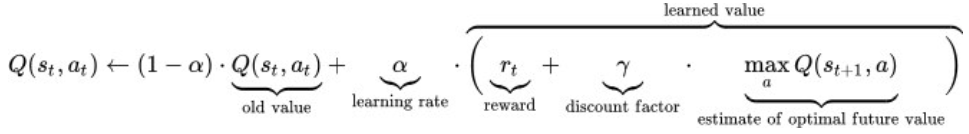

In [27]:
from IPython.display import Image
Image(filename='Q.png')

In [28]:
print('Initial incoming delivery:',100)
print('Max Inventory/Backlog Possible:', max_inventory)
print('Outgoing Orders Possible:', all_possible_actions)
print("Transport delay in week:", time_delay)
print("minium cost:", min_cost)

Initial incoming delivery: 100
Max Inventory/Backlog Possible: 1000
Outgoing Orders Possible: [  0  10  50 100 200 300 400 500 600]
Transport delay in week: 1
minium cost: 0


Now that we set the environnement :



- Set manually the values of the variables
- Create and return the environment for the reinforcement learning

In [29]:
from main import ProductionLine

In [30]:
def Warehouse(inventory=500, backlog=0, incoming_delivery=10, 
              inventory_cost=0.5, backlog_cost=1):
    
    
    # initialize states
    env = ProductionLine(inventory=inventory, backlog=backlog, incoming_delivery=incoming_delivery, )
    
    # set holding, backlog cost
    env.set_cost(inventory_cost=inventory_cost, backlog_cost=backlog_cost)
    
    return env

In [31]:
np.random.seed(42)
time_delay=1
# Set Production line object
warehouse = Warehouse()

# set initial Q values for all the states
n_states = warehouse.all_states()


In [32]:
# function to read policy to be generated as a pickle (byte object)
def read_Q(file_name='Q_value.pickle'):
    # read Q table
    with open(file_name, 'rb') as file:
        Q = pickle.load(file)
    return Q

### set training/testing on number of episodes

In [33]:
train = True

if train:
    # total number of episode
    episodes = 3000
else:
    episodes = 3

In [34]:
def get_incoming_order(mean, sd):
    # function to get the customer order
    return int(np.random.normal(mean, sd))

def get_incoming_order_stats(df, column):
    df = pd.read_csv(df)
    return df[[column]].mean(), df[[column]].std()

In [35]:
# incoming order csv
incoming_order_csv = 'Incoming_Order.csv'

# incoming order column
io_column = 'Incoming_Order'

* The next code needs to be in the same cell to work efficiently for the looping so steps are detailed beforehand
* comments on most lines of codes are added

### Greedy Q Policy 
Steps:
- set initial Q values for all the states
- learning optimal values by simulating different episodes
- dataframe to store data while training
- train an RL agent and return Policy (Q value metrics) and the training dataframe
- determine the policy from Q*


In [37]:
import numpy as np
np.random.seed(42)

all_possible_actions = np.array([0, 10, 50, 100, 200, 300, 400, 500, 600])

# supplychain object
warehouse = Warehouse()

# set initial Q values for all the states
n_states = warehouse.all_states()
if train:
    Q = np.zeros((len(n_states), len(all_possible_actions)))
else:
    Q = read_Q()
    
update_counts = np.zeros((len(n_states), len(all_possible_actions)))
sa_count = np.ones((len(n_states), len(all_possible_actions)))

if train:
    # dataframe to store data while training
    warehouse_data = pd.DataFrame({
                    'Current_Inventory':[],
                    'Backlog_Orders':[],
                    'Incoming_Delivery':[],
                    'Outgoing_Delivery':[],
                    'Outgoing_Order':[],
                    'Incoming_Order':[],
                    'Closing_Inventory':[],
                    'Closing_Backlog':[],
                    'State':[],
                    'Pending_Delivery':[],
                    'Total_Cost':[],
                    'week':[],
                })
else:
    # dataframe to store data while training
    warehouse_data_test = pd.DataFrame({
                    'Current_Inventory':[],
                    'Backlog_Orders':[],
                    'Incoming_Delivery':[],
                    'Outgoing_Delivery':[],
                    'Outgoing_Order':[],
                    'Incoming_Order':[],
                    'Closing_Inventory':[],
                    'Closing_Backlog':[],
                    'State':[],
                    'Pending_Delivery':[],
                    'Total_Cost':[],
                    'week':[],
                })
    
# get incoming order data
mean, sd = get_incoming_order_stats(incoming_order_csv, io_column)

n = 1              
# repeat for n episodes
for episode in tqdm(range(episodes)):
    if train:
        # decaying epsilon for explore exploit of choosing action
        if episode%100 == 0:
            eps = 1/n
            n += 1
    else:
        eps = 0
        
    # initialize warehouse
    warehouse = Warehouse()
    
    # get incoming order
    warehouse.incoming_order = get_incoming_order(mean, sd)

    # update outgoing delivery and next inventory, backlog
    warehouse.update()

    rewards = [0]
    states = []
    actions = []
    
    # get current state of warehouse
    s = warehouse.current_state()
    # append current state
    states.append(s)
    
    # choose an action based on max Q value of current state
    a = max_dict(Q[s])[0]
    # append current state's action
    actions.append(a)       
    
    # loop until one episode is over
    while not warehouse.year_over():
        a = random_action(a, eps)   # epsilon greedy
        
        # update current state's action
        actions[-1] = a
        
        # get outgoing order/action for the current state
        action = all_possible_actions[a]    
    
        # set outgoing_order based on the action to be taken
        warehouse.outgoing_order[time_delay-1] = action

        if train:
            # update the warehouse dataframe
            warehouse_data = warehouse.set_data(warehouse_data)
        else:
            # update the warehouse dataframe
            warehouse_data_test = warehouse.set_data(warehouse_data_test)

        # get cost of current week & update the next week values as current week
        r = warehouse.reward_update()
        # append reward on taking the current action on current state
        rewards.append(r)

        # get incoming order
        warehouse.incoming_order = get_incoming_order(mean, sd)

        # update outgoing delivery and next inventory, backlog
        warehouse.update()

        # get next state
        s1 = warehouse.current_state()
        # append next state
        states.append(s1)
        #print('next:', s, s1)


        a1, max_Q1 = max_dict(Q[s1])
        # append next state's action
        actions.append(a1)
        

        if train:
            
            # discount factor
            gamma = 0.9
            
            # learning rate
            alpha = 0.1

            # tau is the time wholse estimate is being updated
            # G += gamma^n * Q[s_(tau+n), a_(tau+n)]
            # Q[s_tau, a_tau] = Q[s_tau, a_tau] + alpha*(G - Q[s_tau, a_tau])
            tau = warehouse.week-1 - n_steps + 1
            if tau >= 0:
                G = 0
                for i in range(tau+1, min(tau+n_steps+1, number_of_weeks+1)):
                    G += np.power(gamma, i-tau-1) * rewards[i]

                if tau + n_steps <= number_of_weeks:
                    G += np.power(gamma, n_steps) * Q[states[tau+n_steps]][actions[tau+n_steps]]
                    sa_count[states[tau]][actions[tau]] += 0.005
                    Q[states[tau], actions[tau]] += (alpha/sa_count[states[tau]][actions[tau]])*(G - Q[states[tau], actions[tau]])
                    
                    # we would like to know how often Q(s) has been updated too
                    update_counts[states[tau]][actions[tau]] += 1
    
        # set next state as current state
        s = s1

        # update next action as current action
        a = a1

if train:
    # determine the policy from Q*
    # initialize policy, V
    policy, V = {}, {}
    for s in range(-n_bins, n_bins+1):
        policy[s] = all_possible_actions[max_dict(Q[s])[0]]

    # what's the proportion of time we spend updating each part of Q?
    #print("update counts:")
    total = np.sum(update_counts)
    for k in range(-n_bins, n_bins+1):
        update_counts[k] =  np.around(update_counts[k]*100 / total, 2)
    #print(update_counts)
    print('Total States Updated:', len([item for item in np.sum(update_counts, axis=1) if item!=0]), 'out of:', len(n_states))
    print('Action Space Size:', len(update_counts))
    
    with open('policy_n.pickle', 'wb') as file:
        pickle.dump(policy, file)
    
    with open('Q_value_n.pickle', 'wb') as file:
        pickle.dump(Q, file)


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [08:05<00:00,  6.18it/s]

Total States Updated: 61 out of: 61
Action Space Size: 61


In [38]:
policy

{-30: 600,
 -29: 600,
 -28: 400,
 -27: 600,
 -26: 500,
 -25: 400,
 -24: 600,
 -23: 600,
 -22: 600,
 -21: 600,
 -20: 500,
 -19: 500,
 -18: 600,
 -17: 600,
 -16: 500,
 -15: 600,
 -14: 600,
 -13: 600,
 -12: 600,
 -11: 500,
 -10: 600,
 -9: 600,
 -8: 500,
 -7: 600,
 -6: 600,
 -5: 600,
 -4: 600,
 -3: 600,
 -2: 600,
 -1: 600,
 0: 600,
 1: 600,
 2: 600,
 3: 200,
 4: 500,
 5: 200,
 6: 300,
 7: 10,
 8: 500,
 9: 300,
 10: 0,
 11: 200,
 12: 0,
 13: 0,
 14: 10,
 15: 10,
 16: 600,
 17: 50,
 18: 300,
 19: 200,
 20: 600,
 21: 100,
 22: 300,
 23: 600,
 24: 100,
 25: 600,
 26: 0,
 27: 50,
 28: 600,
 29: 500,
 30: 500}

### generated training data

In [41]:
t=1
warehouse_data.iloc[number_of_weeks*(t-1):number_of_weeks*t]

,Current_Inventory,Backlog_Orders,Incoming_Delivery,Outgoing_Delivery,Outgoing_Order,Incoming_Order,Closing_Inventory,Closing_Backlog,State,Pending_Delivery,Total_Cost,week
0,500.0,0.0,10.0,428.0,200.0,428.0,82.0,0.0,2.0,0.0,41.0,0.0
1,82.0,0.0,102.0,184.0,400.0,390.0,0.0,206.0,-6.0,98.0,247.0,1.0
2,0.0,206.0,428.0,428.0,50.0,278.0,0.0,56.0,-1.0,70.0,303.0,2.0
3,0.0,56.0,91.0,91.0,500.0,369.0,0.0,334.0,-10.0,29.0,637.0,3.0
4,0.0,334.0,520.0,520.0,50.0,400.0,0.0,214.0,-6.0,9.0,851.0,4.0
5,0.0,214.0,52.0,52.0,600.0,373.0,0.0,535.0,-16.0,7.0,1386.0,5.0
6,0.0,535.0,137.0,137.0,10.0,423.0,0.0,821.0,-24.0,470.0,2207.0,6.0
7,0.0,821.0,473.0,473.0,10.0,448.0,0.0,796.0,-23.0,7.0,3003.0,7.0
8,0.0,796.0,16.0,16.0,400.0,362.0,0.0,1142.0,-30.0,1.0,4145.0,8.0
9,0.0,1142.0,264.0,264.0,0.0,381.0,0.0,1259.0,-30.0,137.0,5404.0,9.0


### Rolling window on Total Cost Optimization

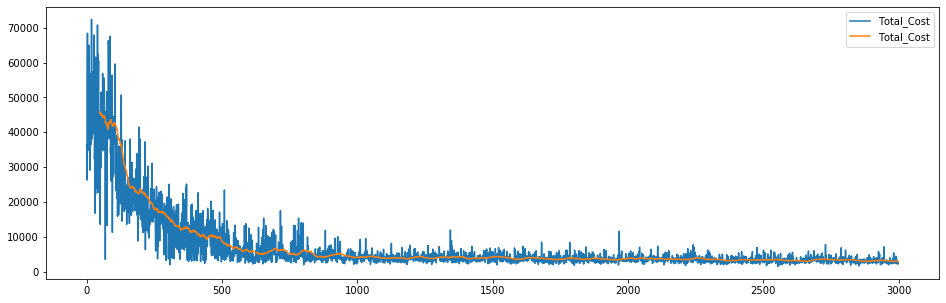

In [70]:
warehouse_data[warehouse_data.week==number_of_weeks-1].reset_index()['Total_Cost'].plot(figsize=(16,5))
warehouse_data[warehouse_data.week==number_of_weeks-1].reset_index()['Total_Cost'].rolling(50).mean().plot()
plt.legend();